In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.signal import butter, lfilter,freqs, freqz,sosfilt, sosfreqz
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft

import numpy as np



In [89]:
#Lectura de archivos
with open("data/mesa_2Hz.txt", "r") as f:
    mesa= f.readlines()

with open("data/DATALOG_2Hz.txt", "r") as f:
    Experimento2Hz= f.readlines()

with open("data/DATALOG_8Hz.txt", "r") as f:
    Experimento8Hz= f.readlines()

with open("data/DATALOG_10Hz.txt", "r") as f:
    Experimento10Hz= f.readlines()


with open("data/DATALOG_10Hz2.txt", "r") as f:
    Experimento10Hz2= f.readlines()


with open("data/DATALOG_20Hz.txt", "r") as f:
    Experimento20Hz= f.readlines()

with open("data/DATALOG_CaidaLibre.txt", "r") as f:
    DATALOG_CaidaLibre= f.readlines()

A_R = 16384.0  #Datalog/A_R da aceleracion     32768/2
G_R = 131.072    #Datalog/G_R da angulo Giroscopio 32768/250


<font size="5">Se estructuran los datos de las pruebas</font>

In [90]:
#Funcion para estructurar Datos (Vector de diccionarios con dimension = numero de reinicios)
#Ejemplo Estructura:
"""   [{'ax': array([-2028, -1892, -2006, ..., -1741, -1755, -1770]),
      'ay': array([  2, 172,  60, ...,  84, -79, 111]),
      'az': array([ 646,  625,  618, ..., 1049, 1036, 1022]),
      'gx': array([-65,  -2, -37, ..., 150, 219, 121]),
      'gy': array([-22,   0, -17, ..., -29, -36, -97]),
      'gz': array([  51,   43,  -33, ...,   57, -135, -211])},
     {'ax': array([-2028, -1892, -2006, ..., -1741, -1755, -1770]),
      'ay': array([  2, 172,  60, ...,  84, -79, 111]),
      'az': array([ 646,  625,  618, ..., 1049, 1036, 1022]),
      'gx': array([-65,  -2, -37, ..., 150, 219, 121]),
      'gy': array([-22,   0, -17, ..., -29, -36, -97]),
      'gz': array([  51,   43,  -33, ...,   57, -135, -211])},
     {'ax': array([-2028, -1892, -2006, ..., -1741, -1755, -1770]),
      'ay': array([  2, 172,  60, ...,  84, -79, 111]),
      'az': array([ 646,  625,  618, ..., 1049, 1036, 1022]),
      'gx': array([-65,  -2, -37, ..., 150, 219, 121]),
      'gy': array([-22,   0, -17, ..., -29, -36, -97]),
      'gz': array([  51,   43,  -33, ...,   57, -135, -211])}] """


def Datalog_DataStruc(Experimento): # Convierte datos sensados en el experimento en datos estructurados
    DatosEstructurados =[] # Contiene los conjuntos de datos de todo el experimento (su dimension esta determinada por el numero de reinicios del experimento)
    Datanp = np.array([[Experimento[i].split(",")[j] for i in range(len(Experimento))] for j in range(6)] ) #Conversion de tipo 
    Inicio_Pruebas = np.where(Datanp == "ax")[1] #Esto contiene una lista con las posiciones de los encabezados
    
    if(len(Inicio_Pruebas) == 1):
        SecData = np.int_(Datanp[:,1 :]) #Selecciona el conjunto de datos entre encabezados
        SecData_Estructurada = dict( zip(  Experimento[0][:-1].split(",")  , SecData ) ) #Se genera un dicionario para tener data estructurada
        DatosEstructurados.append(SecData_Estructurada) #Se agrega el conjunto de datos
        return DatosEstructurados
    else:
        for i in range(1,len(Inicio_Pruebas)):
            SecData = np.int_(Datanp[    :  ,    Inicio_Pruebas[i-1]+1 : Inicio_Pruebas[i]-1     ]) #Selecciona el conjunto de datos entre encabezados
            SecData_Estructurada = dict( zip(  Experimento[0][:-1].split(",")  , SecData ) ) #Se genera un dicionario para tener data estructurada
            DatosEstructurados.append(SecData_Estructurada) #Se agrega el conjunto de datos
        return DatosEstructurados
    
def RecortarData(Datos_Experimento,fs,ti,tf):  #Graficar Datos estructurados del experimento, con conversion de unidades
    A = int(fs*ti)
    B = int(fs*tf)
    Data = {}
    Data["ax"] = Datos_Experimento["ax"][A:B]
    Data["ay"] = Datos_Experimento["ay"][A:B]
    Data["az"] = Datos_Experimento["az"][A:B]
    Data["gx"] = Datos_Experimento["gx"][A:B]
    Data["gy"] = Datos_Experimento["gy"][A:B]
    Data["gz"] = Datos_Experimento["gz"][A:B]
    return Data

def Graficar_DataExperimento(Datos_Experimento,fs):  #Graficar Datos estructurados del experimento, con conversion de unidades
    t = np.arange(len(   Datos_Experimento["ax"]    ))/fs

    plt.figure(1, figsize = [15,5])
    plt.title("Aceleraciones")
    plt.ylabel('Aceleracion [g]')
    plt.xlabel('t [s]')
    plt.plot(t, Datos_Experimento["ax"]/A_R,label='ax')
    plt.plot(t, Datos_Experimento["ay"]/A_R,label='ay')
    plt.plot(t, Datos_Experimento["az"]/A_R,label='az')
    plt.legend(loc='upper center')
    

    plt.figure(2, figsize = [15,5])
    plt.title("Angulos Giroscopio")
    plt.ylabel('Angulo [°]')
    plt.xlabel('t [s]')
    plt.plot(t, Datos_Experimento["gx"]/G_R,label='gx')
    plt.plot(t, Datos_Experimento["gy"]/G_R,label='gy')
    plt.plot(t, Datos_Experimento["gz"]/G_R,label='gz')
    plt.legend(loc='upper center')
   
    
    
def Aceleracion_to_angulo(Datos_Experimento): # Calcula phi y theta apartir de aceleraciones aceleraciones
    ax = Datos_Experimento["ax"]/A_R
    ay = Datos_Experimento["ay"]/A_R
    az = Datos_Experimento["az"]/A_R
    
    
    _Φ = np.arctan(  -ax / np.sqrt(ay**2 + az**2))
    _θ = np.arctan(  ay / np.sqrt(ax**2 + az**2))
    return [_Φ, _θ]

def MagnitudAceleracion(Datos_Experimento): # Calcula la magnitud de la aceleracion
    ax = Datos_Experimento["ax"]/A_R
    ay = Datos_Experimento["ay"]/A_R
    az = Datos_Experimento["az"]/A_R
    
    return np.sqrt(ax**2+ay**2+az**2)

def FiltroComplementario(theta,G,theta_a,dt,A,B): #Aplica filtro complementario a datos de la IMU
    return A*(theta + G*dt) + B*theta_a

def Get_Angulos(Datos_Experimento,fs):  # Obtiene los angulos en cada instante de tiempo utilizando el FiltroComplementario
    Φ_a , θ_a = Aceleracion_to_angulo(Datos_Experimento)
    yaw_a = np.zeros( len(Φ_a)  )
    
    θ = np.empty( len(Φ_a) -1 )
    Φ = np.empty( len(Φ_a) -1 )
    yaw = np.empty( len(Φ_a) -1 )
    G_x = Datos_Experimento["gx"]/G_R
    G_y = Datos_Experimento["gy"]/G_R
    G_z = Datos_Experimento["gz"]/G_R

    for i in range(1,len(Φ_a)-1):
        θ[i] = FiltroComplementario(θ[i-1],G_x[i-1],θ_a[i-1],1/fs,0.98,0.02)
        Φ[i] = FiltroComplementario(Φ[i-1],G_y[i-1],Φ_a[i-1],1/fs,0.98,0.02)
        yaw[i] = FiltroComplementario(yaw[i-1],G_z[i-1],yaw_a[i-1],1/fs,1,0.0)
    return θ , Φ , yaw
    
    
def FFT(Data,fs):
    N = len(Data)
    T = 1/fs
    yf = fft(Data)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    return [xf, yf, N]



def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a


def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass( highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [91]:
#Se transforman los datos en una lista de diccionarios (Clave = Cabecera, Valor = Columna de su respectiva cabecera)
Datos_mesa= Datalog_DataStruc(mesa)
Datos_Experimento2Hz = Datalog_DataStruc(Experimento2Hz)
Datos_Experimento8Hz = Datalog_DataStruc(Experimento2Hz)
Datos_Experimento10Hz = Datalog_DataStruc(Experimento10Hz)
Datos_Experimento10Hz2 = Datalog_DataStruc(Experimento10Hz2)
Datos_Experimento20Hz = Datalog_DataStruc(Experimento20Hz)
CaidaLibre = Datalog_DataStruc(DATALOG_CaidaLibre)

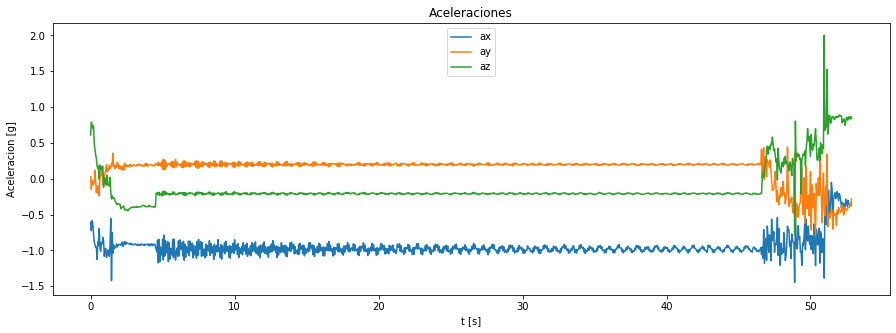

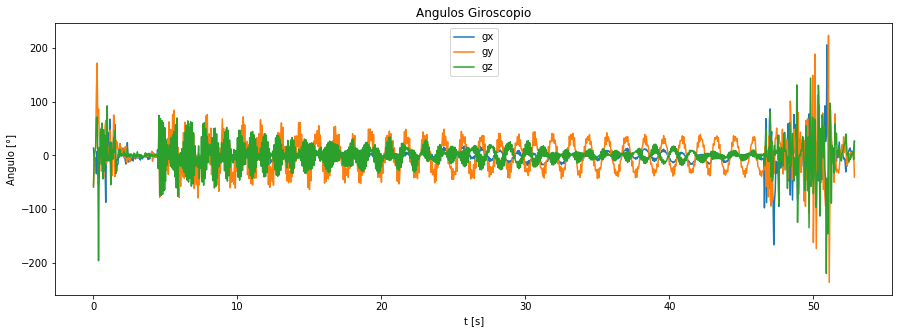

In [92]:
fs = 20 #Frecuencia de muestreo
Graficar_DataExperimento(Datos_Experimento20Hz[1],fs) # Grafica muestras de aceleracion y giroscopio de la IMU

<font size="5"> Se selecciona el rango de tiempo para realizar el analisis 

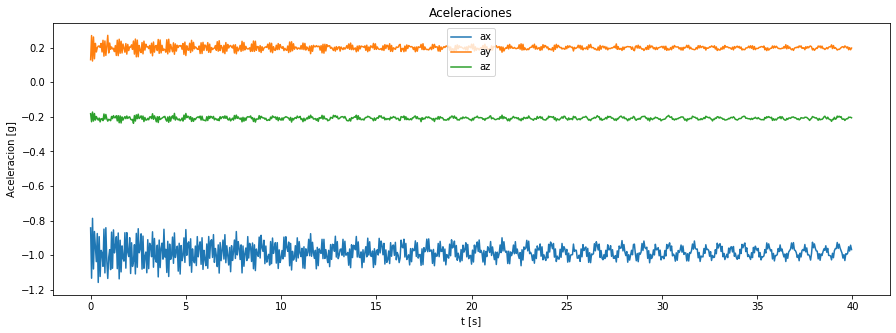

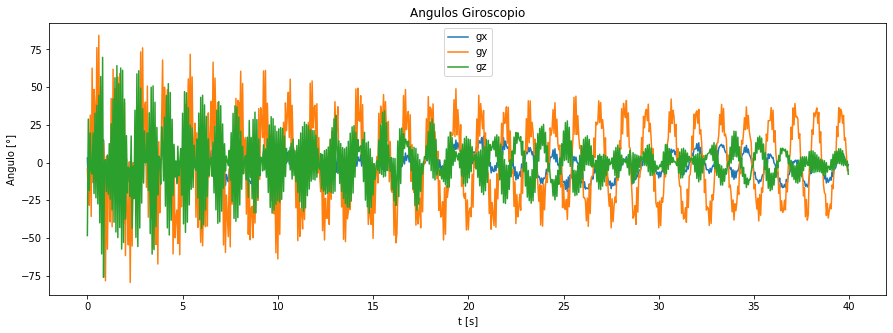

In [93]:
Data = RecortarData(Datos_Experimento20Hz[1],fs,5,45)   # RecortarData(Data, Frecuencia de muestreo, Tinicio, TFinal)
Graficar_DataExperimento(Data,fs) # Grafica muestras de aceleracion y giroscopio de la IMU


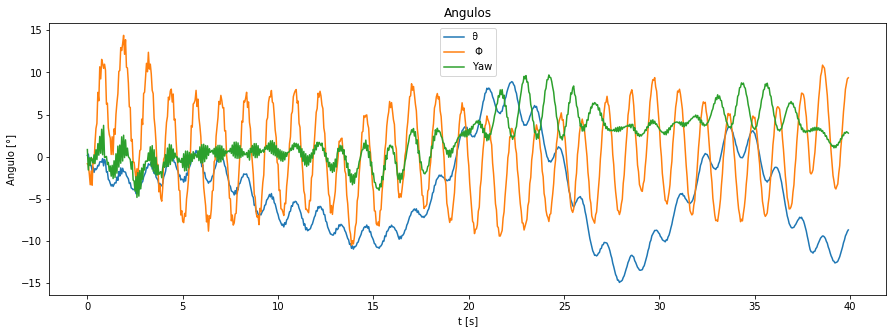

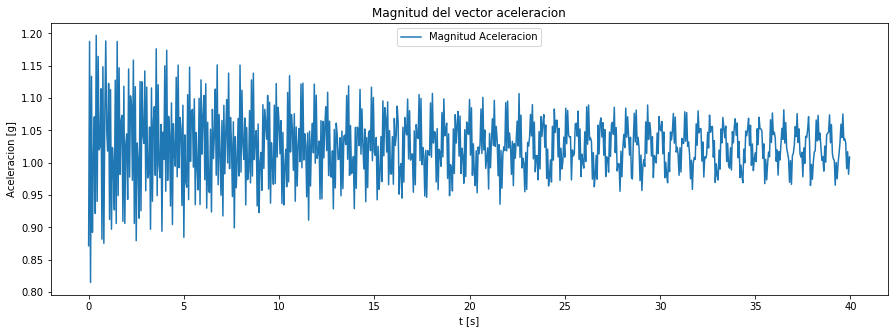

In [94]:
#Se obtienen angulos apartir de aceleraciones para experimento con frecuencia de muestreo de 20Hz
θ , Φ, yaw = Get_Angulos(Data,fs) # Obtiene angulos con Filtro complementario
t_angulos = np.arange(len( θ ))/fs 

M_Aceleracion = MagnitudAceleracion(Data)
t_Aceleracion = np.arange(len( M_Aceleracion) )/fs


plt.figure(1, figsize = [15,5])
plt.title("Angulos")
plt.ylabel('Angulo [°]')
plt.xlabel('t [s]')
plt.plot(t_angulos, θ,label='θ')
plt.plot(t_angulos, Φ,label=' Φ')
plt.plot(t_angulos, yaw,label='Yaw')
plt.legend(loc='upper center')

plt.figure(2, figsize = [15,5])
plt.title("Magnitud del vector aceleracion")
plt.ylabel('Aceleracion [g]')
plt.xlabel('t [s]')
plt.plot(t_Aceleracion, M_Aceleracion,label='Magnitud Aceleracion')
plt.legend(loc='upper center')

<font size="5">  Observando en Frecuencia

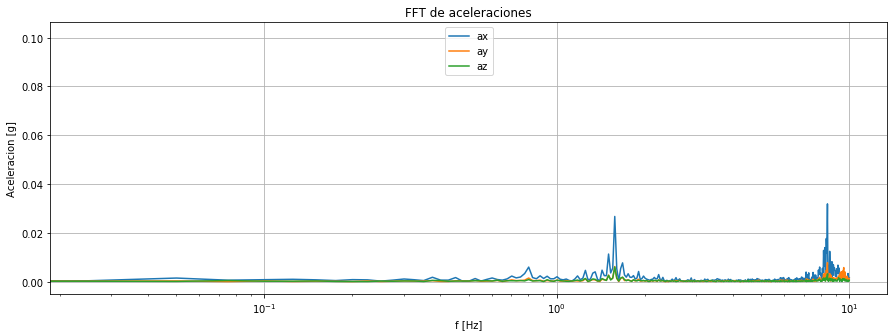

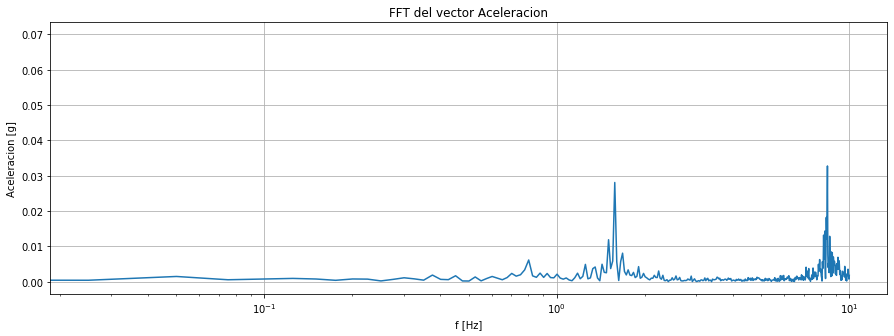

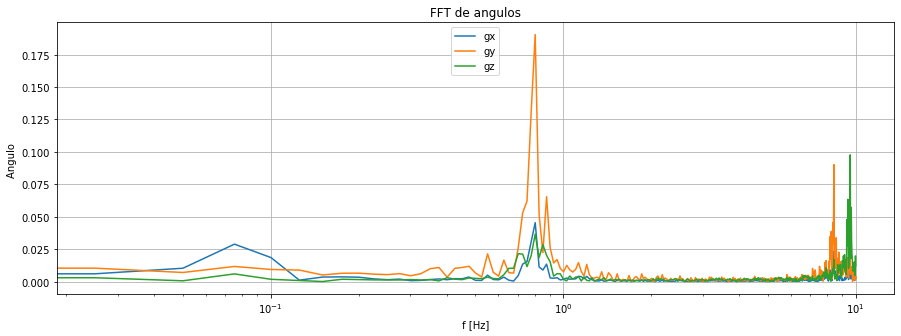

In [95]:
FFT_a = {} #FFT de aceleraciones
f_a = {} #Frecuencias de la FFT de aceleraciones
N_a = {} #Numero de muestras de las aceleraciones

FFT_g = {} #FFT de angulos
f_g = {} #Frecuencias de la FFT de angulos
N_g = {} #Numero de muestras de lasangulos


f_a["ax"],FFT_a["ax"],N_a["ax"] = FFT(Data["ax"]/A_R+1,fs) # Se quita a la brava la componente de DC dada por la gravedad 
f_a["ay"],FFT_a["ay"],N_a["ay"] = FFT(Data["ay"]/A_R-0.25,fs) # Se quita a la brava la componente de DC dada por la gravedad
f_a["az"],FFT_a["az"],N_a["az"] = FFT(Data["az"]/A_R+0.2,fs) # Se quita a la brava la componente de DC dada por la gravedad
f_a["Ma"],FFT_a["Ma"],N_a["Ma"] = FFT(M_Aceleracion-1.06,fs) # Se quita a la brava la componente de DC dada por la gravedad

f_a["gx"],FFT_a["gx"],N_a["gx"] = FFT(Data["gx"]/A_R,fs) 
f_a["gy"],FFT_a["gy"],N_a["gy"] = FFT(Data["gy"]/A_R,fs) 
f_a["gz"],FFT_a["gz"],N_a["gz"] = FFT(Data["gz"]/A_R,fs) 


plt.figure(1, figsize = [15,5])
plt.title("FFT de aceleraciones")
plt.ylabel('Aceleracion [g]')
plt.xlabel('f [Hz]')
plt.plot(f_a["ax"], 2.0/N_a["ax"] * np.abs(FFT_a["ax"][0:N_a["ax"]//2]),label='ax')
plt.plot(f_a["ay"], 2.0/N_a["ay"] * np.abs(FFT_a["ay"][0:N_a["ay"]//2]),label='ay')
plt.plot(f_a["az"], 2.0/N_a["az"] * np.abs(FFT_a["az"][0:N_a["az"]//2]),label='az')
plt.xscale('log')
plt.legend(loc='upper center')
plt.grid()
plt.show()

plt.figure(2, figsize = [15,5])
plt.title("FFT del vector Aceleracion")
plt.ylabel('Aceleracion [g]')
plt.xlabel('f [Hz]')
plt.plot(f_a["Ma"], 2.0/N_a["Ma"] * np.abs(FFT_a["Ma"][0:N_a["Ma"]//2]),label='Magnitud aceleraciones')
plt.xscale('log')
plt.grid()
plt.show()


plt.figure(3, figsize = [15,5])
plt.title("FFT de angulos")
plt.ylabel('Angulo ')
plt.xlabel('f [Hz]')
plt.plot(f_a["gx"], 2.0/N_a["gx"] * np.abs(FFT_a["gx"][0:N_a["gx"]//2]),label='gx')
plt.plot(f_a["gy"], 2.0/N_a["gy"] * np.abs(FFT_a["gy"][0:N_a["gy"]//2]),label='gy')
plt.plot(f_a["gz"], 2.0/N_a["gz"] * np.abs(FFT_a["gz"][0:N_a["gz"]//2]),label='gz')
plt.xscale('log')
plt.legend(loc='upper center')
plt.grid()
plt.show()



<font size="5">  Aplicando Filtros a las señales medidas para eliminar ruido

In [96]:
Freq_filtro_a = [1.2,1.8]
Freq_filtro_g = [0.4,1]
                 
Data_Filtrada = {}
Data_Filtrada["ax"] = butter_bandpass_filter(Data["ax"]/A_R,1.2,1.8,fs,order=2 )
Data_Filtrada["ay"] = butter_bandpass_filter(Data["ay"]/A_R,1.2,1.8,fs,order=2 )
Data_Filtrada["az"] = butter_bandpass_filter(Data["az"]/A_R,1.2,1.8,fs,order=2 )
Data_Filtrada["Ma"] = butter_bandpass_filter(M_Aceleracion-1,1.2,1.8,fs,order=2 )
                 
Data_Filtrada["gx"] = butter_lowpass_filter(Data["gx"]/G_R,0.8,fs,order=2 )
Data_Filtrada["gy"] = butter_lowpass_filter(Data["gy"]/G_R,0.8,fs,order=2 )
Data_Filtrada["gz"] = butter_lowpass_filter(Data["gz"]/G_R,0.8,fs,order=2 )
                 

<font size="5">  Se grafican señales filtradas

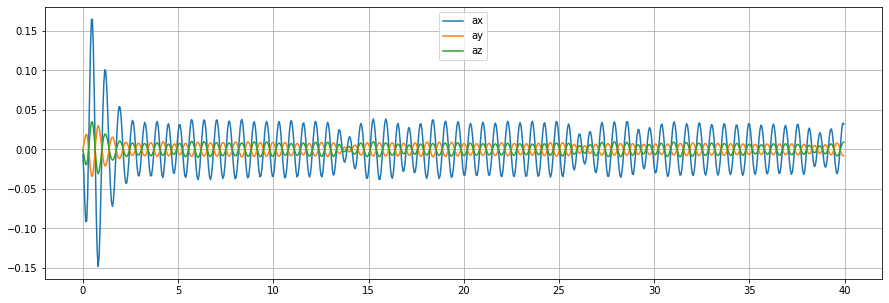

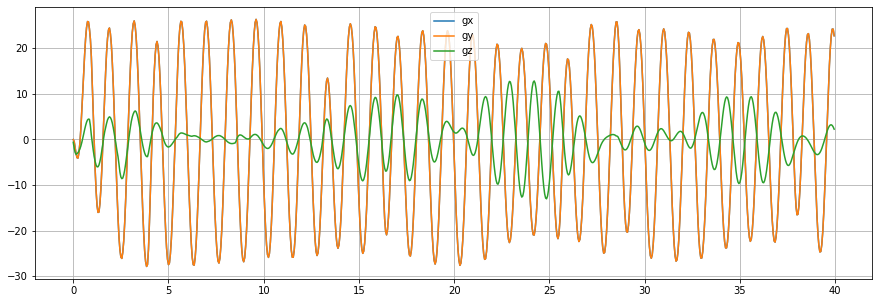

In [97]:
plt.figure(1, figsize = [15,5])
t = np.arange(len( Data_Filtrada["Ma"]) )/fs
plt.plot(t, Data_Filtrada["ax"],label='ax')
plt.plot(t, Data_Filtrada["ay"],label='ay')
plt.plot(t, Data_Filtrada["az"],label='az')
#plt.plot(t, Data_Filtrada["Ma"],label='Ma')

plt.legend(loc='upper center')
plt.grid()
plt.show()

plt.figure(2, figsize = [15,5])
t = np.arange(len( Data_Filtrada["Ma"]) )/20
plt.plot(t, Data_Filtrada["gy"],label='gx')
plt.plot(t, Data_Filtrada["gy"],label='gy')
plt.plot(t, Data_Filtrada["gz"],label='gz')
plt.legend(loc='upper center')
plt.grid()
plt.show()

In [98]:
#calcula la derivada de Data
def Derivada(Data):
    derivada = np.empty(len(Data)-1)
    for i in range(len(Data)-1):
        derivada[i] = Data[i+1] - Data[i]
    return derivada

derivada = Derivada(Data_Filtrada["Ma"])

In [99]:
#Genera vector con minimos
def Cruce_cero_decreciente(Data):
    return [i for i in range(len(Data)-1) if(Data[i+1] > 0 and Data[i] < 0)]

def Cruce_cero_creciente(Data):
    return [i for i in range(len(Data)-1) if(Data[i+1] < 0 and Data[i] > 0)]

Minimos = Cruce_cero_decreciente(derivada)  # Esto halla un minimo de la integral(señal original) de derivada 


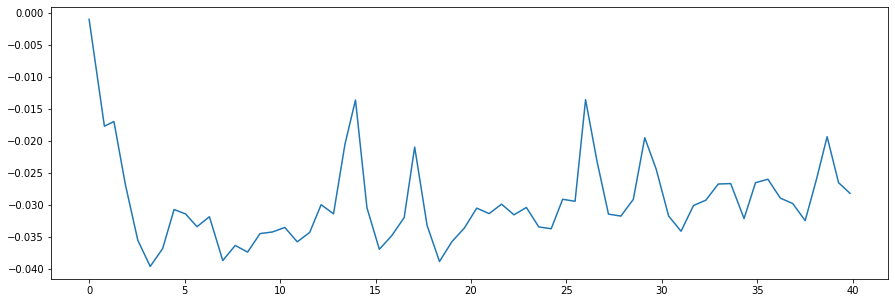

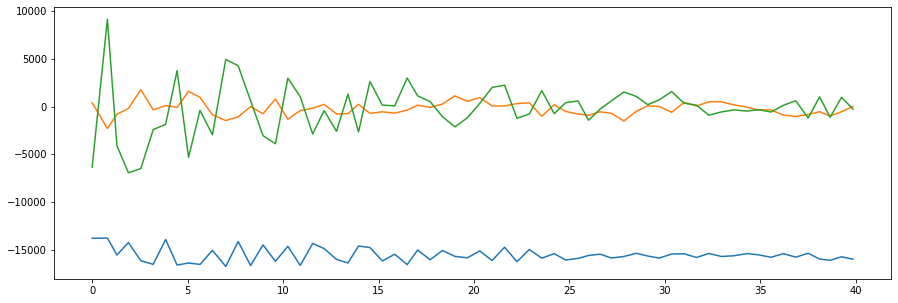

In [100]:
#Buscando relaciones :()

plt.figure(1, figsize = [15,5])
t = np.arange(len( Data_Filtrada["Ma"]) )/fs


plt.plot(t[Minimos], Data_Filtrada["Ma"][Minimos],label='Magnitud Aceleracion pasband')

plt.figure(3, figsize = [15,5])

plt.plot(t[Minimos],  Data["ax"][Minimos],label='Magnitud Aceleracion pasband')
plt.plot(t[Minimos],  Data["gx"][Minimos],label='Magnitud Aceleracion pasband')
plt.plot(t[Minimos],  Data["gz"][Minimos],label='Magnitud Aceleracion pasband')
